In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import yt
from yt.units import dimensions
from yt.visualization.fixed_resolution import FixedResolutionBuffer

import numpy as np
import matplotlib.pyplot as plt

from sim import *
from read_ramses import *
from functions import *
import const


In [5]:
# choose simulation
sim_round = 9
sim_name = "fiducial"
sim_dir = move_to_sim_dir(sim_round, sim_name)
print()

dump = get_dump(aexp=0.0946)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.aexp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.

Dump: 45
a_exp: 0.0951
Maximum AMR level: 13


In [6]:
info_file = os.path.join("output_%.5d" % dump, "info_%.5d.txt" % dump)
ds = yt.load(info_file)


yt : [INFO     ] 2024-02-05 16:10:57,288 Parameters: current_time              = 4.109245114377646
yt : [INFO     ] 2024-02-05 16:10:57,288 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-02-05 16:10:57,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-05 16:10:57,289 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-05 16:10:57,289 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-02-05 16:10:57,290 Parameters: current_redshift          = 9.51745677111818
yt : [INFO     ] 2024-02-05 16:10:57,290 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2024-02-05 16:10:57,290 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2024-02-05 16:10:57,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-02-05 16:10:57,291 Parameters: hubble_constant           = 0.703000030517578


In [7]:
use_cubic = True
use_override = False

halo_cat = get_halo_cat(dump, cgs=True)
biggest_halo_idx = np.argmax(halo_cat.mass)
biggest_halo_coord_mass = halo_cat.coord[:, biggest_halo_idx]
biggest_halo_coord_cubic = get_biggest_halo_coord_cubic(info.aexp) * info.length_unit
biggest_halo_coord_override = np.array([0.51004614, 0.51205933, 0.49348628]) * info.length_unit

print("Halo coord (mass): (%.5g, %.5g, %.5g)" % tuple(biggest_halo_coord_mass / info.length_unit))
print("Halo coord (cubic): (%.5g, %.5g, %.5g)" % tuple(biggest_halo_coord_cubic / info.length_unit))

if use_override: 
    biggest_halo_coord = biggest_halo_coord_override
elif use_cubic:
    biggest_halo_coord = biggest_halo_coord_cubic
else:
    biggest_halo_coord = biggest_halo_coord_mass
    
biggest_halo_coord_code = biggest_halo_coord / info.length_unit


Halo coord (mass): (0.51234, 0.50813, 0.49309)
Halo coord (cubic): (0.51012, 0.51216, 0.49343)


In [8]:
# define size and resolution of the region of interest

# tiny grid
amr_level = 13
box_size = 5 * const.kpc

# small grid
#amr_level = 12
# box_size = 8 * const.kpc

# medium grid
#amr_level = 11
#box_size = 20 * const.kpc

# large grid
# amr_level = 8
# box_size = 100 * const.kpc

left_edge = biggest_halo_coord - box_size / 2
left_edge_code = left_edge / info.length_unit
N = int(box_size / info.length_unit * ds.domain_dimensions[0] * 2**amr_level)
lowres = 2**(info.amr_level_max - amr_level)

print("Grid size: %d" % N)
print("Lowres factor: %d" % lowres)


Grid size: 387
Lowres factor: 1


In [9]:
# get raw yt data from the region of interest

smooth_grid = True

if smooth_grid:
    data = ds.smoothed_covering_grid(level=amr_level, left_edge=left_edge_code, dims=[N]*3)
else:
    data = ds.covering_grid(level=amr_level, left_edge=left_edge_code, dims=[N]*3)


yt : [INFO     ] 2024-02-05 16:11:48,165 Adding particle_type: DM
yt : [INFO     ] 2024-02-05 16:11:48,174 Adding particle_type: star
yt : [INFO     ] 2024-02-05 16:11:48,183 Adding particle_type: cloud
yt : [INFO     ] 2024-02-05 16:11:48,192 Adding particle_type: dust
yt : [INFO     ] 2024-02-05 16:11:48,202 Adding particle_type: star_tracer
yt : [INFO     ] 2024-02-05 16:11:48,211 Adding particle_type: cloud_tracer
yt : [INFO     ] 2024-02-05 16:11:48,221 Adding particle_type: dust_tracer
yt : [INFO     ] 2024-02-05 16:11:48,230 Adding particle_type: gas_tracer


density max: [0.5100974  0.51215895 0.4934068 ]
star barycenter: [0.51010082 0.51215235 0.49340627]
dm barycenter: [0.51011207 0.51215779 0.49341236]


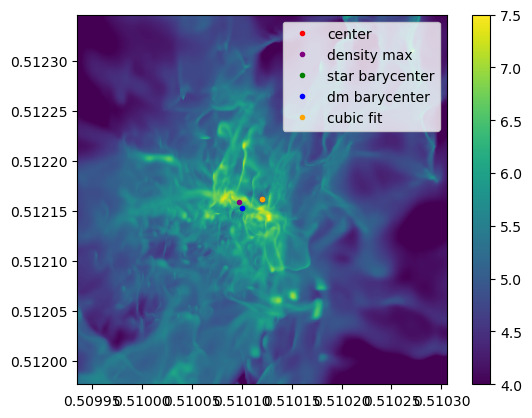

In [10]:
# quick look at the data

idx_slice = Z
idx_coord1, idx_coord2 = np.sort([(idx_slice+1)%3, (idx_slice+2)%3])

particle_type = data["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM
is_star = particle_type == STAR

coord_star_code = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]]))
mass_star_code = data["io", "particle_mass"][is_star].value

coord_dm_code = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]]))
mass_dm_code = data["io", "particle_mass"][is_dm].value

coord_code = np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])
density_code = data["ramses", "Density"].value

plt.imshow(np.log10(np.sum(density_code, axis=idx_slice)).T, extent=[left_edge_code[idx_coord1], left_edge_code[idx_coord1] + box_size / info.length_unit, left_edge_code[idx_coord2], left_edge_code[idx_coord2] + box_size / info.length_unit], origin='lower', vmin=4, vmax=7.5)

x_idx, y_idx, z_idx = np.array(np.where(density_code == np.max(density_code))).T[0]
coord_code_density_max = coord_code[:, x_idx, y_idx, z_idx]
coord_code_star_barycenter = np.sum(coord_star_code * mass_star_code, axis=(1)) / np.sum(mass_star_code)
coord_code_dm_barycenter = np.sum(coord_dm_code * mass_dm_code, axis=(1)) / np.sum(mass_dm_code)

print("density max: %s" % coord_code_density_max)
print("star barycenter: %s" % coord_code_star_barycenter)
print("dm barycenter: %s" % coord_code_dm_barycenter)

plt.plot(left_edge_code[idx_coord1] + box_size / info.length_unit / 2, left_edge_code[idx_coord2] + box_size / info.length_unit / 2, '.', color='red', label='center')
plt.plot(coord_code_density_max[idx_coord1], coord_code_density_max[idx_coord2], '.', color='purple', label='density max')
plt.plot(coord_code_star_barycenter[idx_coord1], coord_code_star_barycenter[idx_coord2], '.', color='green', label='star barycenter')
plt.plot(coord_code_star_barycenter[idx_coord1], coord_code_star_barycenter[idx_coord2], '.', color='blue', label='dm barycenter')
plt.plot(biggest_halo_coord_cubic[idx_coord1] / info.length_unit, biggest_halo_coord_cubic[idx_coord2] / info.length_unit, '.', color='orange', label='cubic fit')
plt.legend()
plt.colorbar()


In [11]:
# read particle data from yt

particle_type = data["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM
is_star = particle_type == STAR

coord_dm = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]])) * info.length_unit - left_edge[:, None] - box_size / 2
mass_dm = data["io", "particle_mass"][is_dm] * info.mass_unit

coord_star = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]])) * info.length_unit - left_edge[:, None] - box_size / 2
mass_star = data["io", "particle_mass"][is_star].value * info.mass_unit
tau_starbirth = data["io", "conformal_birth_time"][is_star].value
id_star = data["io", "particle_identity"][is_star].value.astype(int)


In [12]:
# read gas data from yt

coord = (np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])) * info.length_unit - left_edge[:, None, None, None] - box_size / 2
density = data["ramses", "Density"].value * info.density_unit
metallicity = data["ramses", "Metallicity"].value 
pressure = data["ramses", "Pressure"].value * info.energy_density_unit
energy_turb = data["ramses", "hydro_scalar_01"].value * info.vel_unit**2
ref_crit = data["ramses", "hydro_scalar_02"].value
b_turb = data["ramses", "hydro_scalar_03"].value
vel_vec = np.array([data["ramses", "x-velocity"].value, data["ramses", "y-velocity"].value, data["ramses", "z-velocity"].value]) * info.vel_unit
dx_local = np.zeros((N, N, N))


In [13]:
# compute local dx

for i, z in enumerate(coord_code[Z][0, 0, :]):
    sl = ds.slice(Z, z)
    bounds = (left_edge[X]/info.length_unit, (left_edge[X]+box_size)/info.length_unit, left_edge[Y]/info.length_unit, (left_edge[Y]+box_size)/info.length_unit)
    frb = FixedResolutionBuffer(sl, bounds, (N, N))
    dx_local[:, :, i] = frb["dx"]
    print(i, end="")


yt : [INFO     ] 2024-02-05 16:13:02,421 Making a fixed resolution buffer of (dx) 387 by 387


0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

In [14]:
grid_name = "data_d%d_l%d_b%d" % (dump, lowres, int(box_size / const.kpc))
print("filename: %s.npz" % grid_name)

filename: data_d45_l1_b5.npz


In [49]:
safe_savez(
    grid_name,
    halo_idx=halo_cat.idx[biggest_halo_idx],
    halo_mass=halo_cat.mass[biggest_halo_idx],
    box_size=box_size,
    left_edge=left_edge,
    N=N,
    coord_dm=coord_dm,
    mass_dm=mass_dm,
    coord_star=coord_star,
    mass_star=mass_star,
    tau_starbirth=tau_starbirth,
    id_star=id_star,
    coord=coord,
    density=density,
    metallicity=metallicity,
    pressure=pressure,
    energy_turb=energy_turb,
    ref_crit=ref_crit,
    b_turb=b_turb,
    vel_vec=vel_vec,
    lowres=lowres,
    dx_local=dx_local,
    **info.__dict__
)
